# Hate speech

### 1. Data import and error removal

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import ntpath
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\marti\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
all_files_paths = glob.glob("hate-speech-dataset/all_files/*.txt")

In [3]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [4]:
all_files_names = [str(ntpath.basename(f)).replace(".txt", "") for f in all_files_paths]

In [5]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline()
        except Exception as ex:
            errors.append((name, str(ex)))

100%|██████████| 10944/10944 [00:02<00:00, 4468.40it/s]


In [6]:
errors

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>"),
 ('13588794_3',
  "'charmap' codec can't decode byte 0x81 in position 54: character maps to <undefined>"),
 ('13595072_1',
  "'charmap' codec can't decode byte 0x8d in position 75: character maps to <undefined>"),
 ('13595072_5',
  "'charmap' codec can't decode byte 0x8d in position 78: character maps to <undefined>"),
 ('14061724_1',
  "'charmap' codec can't decode byte 0x81 in position 181: character maps to <undefined>"),
 ('14065492_1',
  "'charmap' codec ca

In [7]:
errors_list = [err[0] for err in errors]

In [8]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()
df.columns = ["file_id", "text"]

In [9]:
df.head()

,file_id,text
0,12834217_1,"As of March 13th , 2014 , the booklet had been..."
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [10]:
ann = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

In [11]:
ann.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [12]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [13]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.shape
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [14]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

### 2. Cleaning and tokenization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### 2.1 Removing links, tags, numbers and bias

In [16]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'), additional, string.punctuation)
data['text_clean'] = data['text'].str.lower()\
    .str.replace('(@[a-z0-9]+)\w+',' ')\
    .str.replace('(http\S+)', ' ')\
    .str.replace('(www\S+)',' ')\
    .str.replace(r'com$', ' ')\
    .str.replace('[0-9]+(?:st| st|nd| nd|rd| rd|th| th)', '')\
    .str.replace('([^a-z \t])',' ')\
    .str.replace(' +',' ')\
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
#any alpha numeric after @ #http # any value except alpha numeric tab character ('\u0009')

In [17]:
# Stemming
ps = PorterStemmer()
data['stemmed'] = data['text_clean'].apply(lambda x: " ".join([ps.stem(i) for i in word_tokenize(x)]))

In [18]:
# Lemmatizer
lm = nltk.WordNetLemmatizer()
data['lemmatized'] = data['text_clean'].apply(lambda x: " ".join([lm.lemmatize(i) for i in word_tokenize(x)]))

In [19]:
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been...",march booklet downloaded times counting,march booklet download time count,march booklet downloaded time counting
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,order help increas booklet download would grea...,order help increase booklet downloads would gr...
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,click free download color illustr page e book ...,click free download colorfully illustrated pag...
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,click download mb green banner link,click download mb green banner link,click download mb green banner link


#### 2.3 Bow and Tfidf

In [20]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])

In [21]:
print(bow_vectorizer.get_feature_names())

['ab', 'abandon', 'abandoned', 'abbey', 'abc', 'abduction', 'abhor', 'abiding', 'ability', 'abit', 'able', 'aboard', 'abominable', 'abomination', 'aborigine', 'aborigional', 'aborted', 'abortion', 'abound', 'abouts', 'abraham', 'abroad', 'absolut', 'absolute', 'absolutely', 'absorbing', 'absurd', 'absurdity', 'abt', 'abundant', 'abuse', 'abused', 'abusing', 'abusive', 'ac', 'acadamys', 'academia', 'academic', 'academy', 'accelerates', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessible', 'accessing', 'accessory', 'accessouries', 'accident', 'accidentally', 'accommonadate', 'accomodation', 'accompaigned', 'accomplice', 'accomplish', 'accomplished', 'accomplishment', 'according', 'accordingly', 'accost', 'account', 'accountable', 'accountant', 'accounted', 'accross', 'accumulate', 'accuracy', 'accurate', 'accurately', 'accusation', 'accuse', 'accused', 'accusing', 'accutrigger', 'ache', 'achieve', 'achieved', 'achievement', 'achiever', 'acitivit

In [22]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
print(tfidf_vectorizer.get_feature_names())

['ago', 'also', 'always', 'anyone', 'anything', 'area', 'around', 'back', 'black', 'child', 'come', 'could', 'country', 'day', 'dont', 'even', 'ever', 'every', 'eye', 'find', 'first', 'friend', 'get', 'girl', 'go', 'god', 'going', 'good', 'got', 'great', 'group', 'guy', 'home', 'hope', 'im', 'ireland', 'jew', 'kid', 'know', 'last', 'let', 'like', 'little', 'live', 'long', 'look', 'looking', 'lot', 'make', 'man', 'many', 'maybe', 'much', 'nationalist', 'need', 'negro', 'never', 'new', 'news', 'non', 'nothing', 'old', 'one', 'people', 'place', 'post', 'put', 'race', 'read', 'really', 'right', 'said', 'saw', 'say', 'school', 'see', 'show', 'someone', 'something', 'start', 'take', 'talk', 'thing', 'think', 'thread', 'time', 'two', 'video', 'want', 'watch', 'way', 'week', 'well', 'white', 'woman', 'work', 'world', 'would', 'year', 'youtube']


In [23]:
pd.DataFrame(X_tfidf[1:11,7:23].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[7:23])

,white,back,world,jew,think,black,every,get,look,hope,one,say,read,well,always,like
0,0.000000,0.000000,0.0,0.0,0.382474,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
6,0.443277,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
9,0.000000,0.377809,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.472976,0.0,0.0,0.0,0.0,0.382452


#### 2.4 Top words

In [24]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [26]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw # Most common words between lemmatized words and frequencies

,words,freq
0,white,1596
1,like,803
2,people,630
3,black,619
4,one,569
5,get,523
6,would,515
7,youtube,470
8,year,420
9,time,396


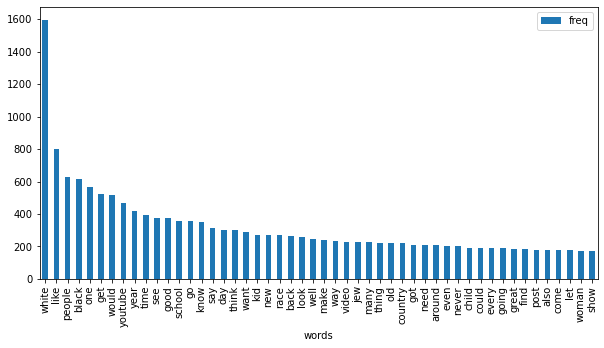

In [27]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5))
plt.show()

In [28]:
data['tokens'] = data['text_clean'].apply(word_tokenize)

#### 2.5 Part of speech (POS)

In [29]:
from textblob import TextBlob
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

In [30]:
from textblob import TextBlob
print(TextBlob(data.iloc[4]["text_clean"]).tags)
print(TextBlob(data.iloc[4]["stemmed"]).tags)

[('click', 'NN'), ('download', 'NN'), ('mb', 'NN'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]
[('click', 'NN'), ('download', 'NN'), ('mb', 'NN'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]


In [31]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [32]:
data['POS_spacy'] = data['lemmatized'].progress_apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

100%|██████████| 10926/10926 [02:41<00:00, 67.67it/s]


In [33]:
all_pos = data['POS_spacy'].sum()

In [34]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [35]:
hate = data.loc[data["label"] == 1]

In [36]:
hate.shape[0], data.shape[0] # 1428 over 10926 rows

(1428, 10926)

In [37]:
data.label.value_counts()

0    9498
1    1428
Name: label, dtype: int64

In [38]:
all_pos_hate = hate['POS_spacy'].sum()

In [39]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

In [40]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj, orient="index", columns=["Freq"]).reset_index()

In [41]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun, orient="index", columns=["Freq"]).reset_index()

In [42]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj1, orient="index", columns=["Freq"]).reset_index()

In [43]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun1, orient="index", columns=["Freq"]).reset_index()

In [44]:
top_noun = {"Total": top_20_noun.keys(), "Freq_Total": top_20_noun.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Total"] = top_noun.apply(lambda x: np.round(x.Freq_Total / top_noun.Freq_Total.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,people,0.147,people,0.137
1,year,0.091,race,0.113
2,time,0.086,country,0.087
3,school,0.064,time,0.063
4,race,0.060,woman,0.057
5,day,0.054,child,0.053
6,thing,0.049,thing,0.053
7,country,0.048,school,0.051
8,child,0.045,way,0.043
9,video,0.044,ape,0.043


In [45]:
common_nouns = list(set(top_noun["Hate_Speech"].values).union(set(top_noun["Total"].values)))

In [46]:
freq_common_tot = [noun_counter[x] for x in common_nouns]
freq_common_hate = [noun_counter1[x] for x in common_nouns]

In [47]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_tot": freq_common_tot, "Freq_Hate_Speech": freq_common_hate })

In [48]:
common_noun_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

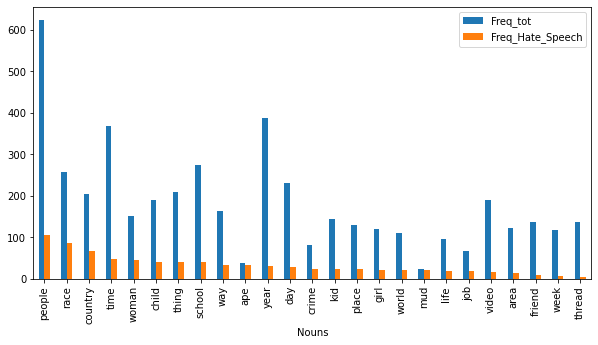

In [49]:
common_noun_df.plot('Nouns', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,5))
plt.show()

In [50]:
top_adj = {"Total": top_20_adj.keys(), "Freq_Total": top_20_adj.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Total"] = top_adj.apply(lambda x: np.round(x.Freq_Total / top_adj.Freq_Total.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.256,white,0.305
1,black,0.125,black,0.196
2,good,0.092,non,0.062
3,many,0.061,good,0.047
4,old,0.053,many,0.042
5,new,0.050,last,0.037
6,last,0.043,negro,0.035
7,great,0.041,little,0.029
8,non,0.036,liberal,0.028
9,little,0.031,much,0.025


In [51]:
common_adj = list(set(top_adj["Hate_Speech"].values).union(set(top_adj["Total"].values)))

In [52]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [53]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_tot": freq_common_tot_adj, "Freq_Hate_Speech": freq_common_hate_adj })

In [54]:
common_adj_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

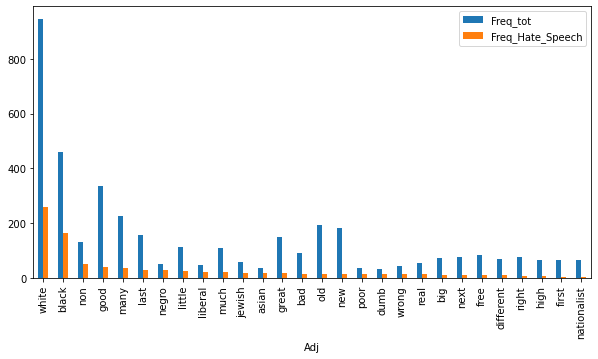

In [55]:
common_adj_df.plot(x='Adj', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,5))
plt.show()

In [56]:
data[data['text'].str.contains("negro")]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,POS_spacy
108,13391410_1,579214,1345,1,1,they act as if negros with aids should have th...,act negros aids right reproduce die way take c...,act negro aid right reproduc die way take care...,act negro aid right reproduce die way take car...,"[act, negros, aids, right, reproduce, die, way...","[(act, VERB), (negro, PROPN), (aid, NOUN), (ri..."
112,13406897_1,579436,1345,0,1,"He's a retarded feral negro ( yes , feral huma...",retarded feral negro yes feral humans cannot t...,retard feral negro ye feral human can not talk...,retarded feral negro yes feral human can not t...,"[retarded, feral, negro, yes, feral, humans, c...","[(retarded, PROPN), (feral, PROPN), (negro, PR..."
114,13406897_3,579436,1345,0,1,I 've seen negroes who look ( and undoubtedly ...,seen negroes look undoubtedly act like,seen negro look undoubtedli act like,seen negro look undoubtedly act like,"[seen, negroes, look, undoubtedly, act, like]","[(seen, VERB), (negro, PROPN), (look, VERB), (..."
230,13503127_1,572147,1345,0,0,Hispanic: A woman threw her 2 1/2-year-old gra...,hispanic woman threw year old granddaughter se...,hispan woman threw year old granddaught sever ...,hispanic woman threw year old granddaughter se...,"[hispanic, woman, threw, year, old, granddaugh...","[(hispanic, ADJ), (woman, NOUN), (threw, VERB)..."
390,14031472_1,596265,1387,2,0,i do this and the looks i get out of disgust a...,looks get disgust regular happily carry walkin...,look get disgust regular happili carri walk la...,look get disgust regular happily carry walking...,"[looks, get, disgust, regular, happily, carry,...","[(look, VERB), (get, AUX), (disgust, VERB), (r..."
...,...,...,...,...,...,...,...,...,...,...,...
9838,12882012_2,577734,1345,0,1,I reported some time ago that negroes will eve...,reported time ago negroes even strip bricks ho...,report time ago negro even strip brick home aw...,reported time ago negro even strip brick home ...,"[reported, time, ago, negroes, even, strip, br...","[(reported, VERB), (time, NOUN), (ago, ADV), (..."
9984,13503418_1,576356,1395,0,1,"Yes, before age of 10 i never saw an negro in ...",yes age never saw negro real life moved hollan...,ye age never saw negro real life move holland ...,yes age never saw negro real life moved hollan...,"[yes, age, never, saw, negro, real, life, move...","[(yes, INTJ), (age, NOUN), (never, ADV), (saw,..."
10397,14413050_1,574116,1375,1,1,Don't stop trying because the negro will prove...,stop trying negro prove right,stop tri negro prove right,stop trying negro prove right,"[stop, trying, negro, prove, right]","[(stop, VERB), (trying, VERB), (negro, ADJ), (..."
10698,30603595_1,573095,1359,3,0,By the way he did n't film the scene for enter...,way n film scene entertainment negro would lie...,way n film scene entertain negro would lie whi...,way n film scene entertainment negro would lie...,"[way, n, film, scene, entertainment, negro, wo...","[(way, PROPN), (n, PROPN), (film, PROPN), (sce..."


In [57]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)}

In [58]:
freq_pos = pd.DataFrame.from_dict(top_pos, orient="index", columns=["Freq"]).reset_index()
freq_pos["R_Freq"] = freq_pos.apply(lambda x: np.round(x.Freq / freq_pos.Freq.sum(), 2), axis=1)

In [59]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [60]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [61]:
compared_pos = {"Total": top_pos.keys(), "Freq_Total": top_pos.values(), "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Total"] = compared_pos.apply(lambda x: np.round(x.Freq_Total / compared_pos.Freq_Total.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos[:7]

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,NOUN,0.287,NOUN,0.280
1,PROPN,0.243,PROPN,0.232
2,VERB,0.200,VERB,0.206
3,ADJ,0.132,ADJ,0.152
4,ADV,0.059,ADV,0.060
5,PRON,0.013,SCONJ,0.012
6,INTJ,0.012,PRON,0.010


# SPELLING

In [62]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [63]:
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab.difference(english_vocab)
    return sorted(unusual)

In [64]:
crt = unusual_words(data['lemmatized'])
print(crt)

['africa', 'aragorn', 'asked', 'asking', 'asmodean', 'bb', 'braun', 'btl', 'bugsy', 'calman', 'camie', 'cf', 'cheaper', 'congrats', 'cripppinnn', 'czynski', 'dallas', 'downloads', 'dr', 'dublin', 'ebonics', 'edmonton', 'einherjer', 'embarassing', 'fbi', 'flanative', 'groupid', 'gyspsies', 'haha', 'hahahahahaha', 'heil', 'hups', 'hz', 'ii', 'iii', 'im', 'internet', 'iv', 'kaboom', 'kid', 'kidding', 'kr', 'lk', 'located', 'lol', 'meh', 'minnesota', 'mmm', 'motivated', 'mrbadgersir', 'msciwoj', 'muahaha', 'needed', 'neofolk', 'nigga', 'nordenwulf', 'okay', 'opendocument', 'opps', 'oz', 'patrioticmama', 'pawel', 'pffffft', 'pm', 'politifuldm', 'reproducing', 'rumour', 'ssupreme', 'stormfront', 'studying', 'sveiks', 'swva', 'tereasa', 'tf', 'threadid', 'tnb', 'topix', 'tv', 'twp', 'ty', 'usa', 'vancouver', 'wehrwolf', 'weku', 'whiteutopian', 'wierd', 'wiki', 'wp', 'wpww', 'wrs', 'wulfi', 'wv', 'youtube', 'yuenglings', 'yup', 'zdrowie', 'zoe']


In [65]:
corrected_w =[TextBlob(word).correct().words[0] for word in crt]
corrected_w

['africa',
 'dragoon',
 'asked',
 'asking',
 'asmodean',
 'by',
 'brain',
 'bal',
 'busy',
 'cabman',
 'came',
 'cf',
 'cheaper',
 'congress',
 'cripppinnn',
 'czynski',
 'dallas',
 'download',
 'dr',
 'dublin',
 'tonics',
 'edmonton',
 'einherjer',
 'embarrassing',
 'foi',
 'flanative',
 'grouped',
 'gypsies',
 'hata',
 'hahahahahaha',
 'heal',
 'huts',
 'he',
 'ii',
 'iii',
 'in',
 'internet',
 'iv',
 'boom',
 'kid',
 'bidding',
 'or',
 'll',
 'located',
 'll',
 'me',
 'minnesota',
 'mmm',
 'motivate',
 'mrbadgersir',
 'msciwoj',
 'muahaha',
 'needed',
 'norfolk',
 'night',
 'nordenwulf',
 'okay',
 'opendocument',
 'open',
 'oz',
 'patrioticmama',
 'panel',
 'pffffft',
 'pm',
 'politifuldm',
 'reproducing',
 'rumour',
 'supreme',
 'stormfront',
 'studying',
 'veins',
 'saw',
 'theresa',
 'of',
 'thread',
 'tub',
 'topic',
 'to',
 'two',
 'ty',
 'us',
 'vancouver',
 'wehrwolf',
 'wetu',
 'whiteutopian',
 'wired',
 'wiki',
 'up',
 'www',
 'was',
 'wolf',
 'we',
 'couture',
 'yuenglings

In [66]:
from autocorrect import Speller
def autocorr(text):
    crt = unusual_words(text)
    for t in crt:
        auto = Speller(lang='en')
        corr = auto(t)
        if t != corr:
            print(t, corr)

In [67]:
autocorr(data['lemmatized']) ##

aragorn dragon
btl bl
bugsy bugs
calman salman
camie came
congrats contrast
embarassing embarrassing
groupid grouped
heil heir
hups ups
kaboom boom
neofolk norfolk
nigga nigra
opps apps
pawel panel
pffffft ffffff
ssupreme supreme
stormfront storefront
sveiks speaks
swva swa
tereasa teresa
threadid threaded
tnb nb
topix topic
wehrwolf werewolf
weku wek
wierd weird
wpww www
wulfi multi


In [68]:
# sentiment polarity TEXTBLOB https://textblob.readthedocs.io/en/dev/quickstart.html

# MODELS

In [69]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10926, 13170)

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [71]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
random_state = np.random.RandomState(0)

In [72]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')
print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[[2693  157]
 [ 322  106]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2850
           1       0.40      0.25      0.31       428

    accuracy                           0.85      3278
   macro avg       0.65      0.60      0.61      3278
weighted avg       0.83      0.85      0.84      3278

0.8538743136058572


In [73]:
# Support Vector Machine
svc = SVC(verbose=10)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')
print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))

[LibSVM][[2847    3]
 [ 407   21]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       0.88      0.05      0.09       428

    accuracy                           0.87      3278
   macro avg       0.87      0.52      0.51      3278
weighted avg       0.87      0.87      0.82      3278

0.8749237339841367


In [74]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')
print(confusion_matrix(y_test,y_log))
print(classification_report(y_test,y_log))
print(accuracy_score(y_test, y_log))

[[2840   10]
 [ 399   29]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2850
           1       0.74      0.07      0.12       428

    accuracy                           0.88      3278
   macro avg       0.81      0.53      0.53      3278
weighted avg       0.86      0.88      0.83      3278

0.87522879804759


In [75]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')
print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))

[[2815   35]
 [ 380   48]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2850
           1       0.58      0.11      0.19       428

    accuracy                           0.87      3278
   macro avg       0.73      0.55      0.56      3278
weighted avg       0.84      0.87      0.83      3278

0.87339841366687


In [76]:
# Neural Networks
NN = MLPClassifier(random_state=42, max_iter=50)
NN.fit(X_train, y_train)
y_NN = NN.predict(X_test)
as_NN = accuracy_score(y_test, y_NN)
f1s_NN = f1_score(y_test, y_NN, average= "macro")
prec_NN = precision_score(y_test, y_NN)
rec_NN = recall_score(y_test, y_NN, average='macro')
print(confusion_matrix(y_test,y_NN))
print(classification_report(y_test,y_NN))
print(accuracy_score(y_test, y_NN))

[[2670  180]
 [ 302  126]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2850
           1       0.41      0.29      0.34       428

    accuracy                           0.85      3278
   macro avg       0.66      0.62      0.63      3278
weighted avg       0.83      0.85      0.84      3278

0.8529591214154972


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [77]:
# Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')
print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))

[[2610  240]
 [ 277  151]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2850
           1       0.39      0.35      0.37       428

    accuracy                           0.84      3278
   macro avg       0.65      0.63      0.64      3278
weighted avg       0.84      0.84      0.84      3278

0.8422818791946308


In [78]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
as_knn = accuracy_score(y_test, y_knn)
f1s_knn = f1_score(y_test, y_knn, average= "macro")
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn, average='macro')
print(confusion_matrix(y_test,y_knn))
print(classification_report(y_test,y_knn))
print(accuracy_score(y_test, y_knn))

[[2850    0]
 [ 420    8]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       1.00      0.02      0.04       428

    accuracy                           0.87      3278
   macro avg       0.94      0.51      0.48      3278
weighted avg       0.89      0.87      0.81      3278

0.8718730933496034


In [79]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_NN, as_tree, as_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_NN, f1s_tree, f1s_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_NN, prec_tree, prec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.853874,0.403042,0.596288,0.612565
Support Vector Machine,0.874924,0.875000,0.524006,0.512876
Logistic Regression,0.875229,0.743590,0.532124,0.528513
Random Forest,0.873398,0.578313,0.549934,0.559608
Neural Networks,0.852959,0.411765,0.615617,0.630267
Decision Tree,0.842282,0.386189,0.634297,0.639313
K-Nearest Neighbors,0.871873,1.000000,0.509346,0.484035


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

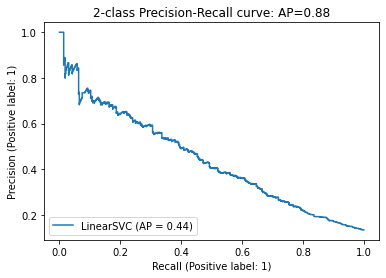

In [80]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prec_svc))

# Imbalanced

In [81]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
undersample = RandomUnderSampler(sampling_strategy='majority')

In [82]:
X_over, y_over = undersample.fit_resample(X_class, y_class)

In [83]:
from collections import Counter
print(Counter(y_over))

Counter({0: 1428, 1: 1428})


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)

In [85]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[[270 159]
 [116 312]]
              precision    recall  f1-score   support

           0       0.70      0.63      0.66       429
           1       0.66      0.73      0.69       428

    accuracy                           0.68       857
   macro avg       0.68      0.68      0.68       857
weighted avg       0.68      0.68      0.68       857

0.6791131855309218


In [86]:
# Support Vector Machine
svc_i = SVC(verbose=10)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))

[LibSVM][[347  82]
 [143 285]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       429
           1       0.78      0.67      0.72       428

    accuracy                           0.74       857
   macro avg       0.74      0.74      0.74       857
weighted avg       0.74      0.74      0.74       857

0.7374562427071178


In [87]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))

[[344  85]
 [129 299]]
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       429
           1       0.78      0.70      0.74       428

    accuracy                           0.75       857
   macro avg       0.75      0.75      0.75       857
weighted avg       0.75      0.75      0.75       857

0.750291715285881


In [88]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

[[327 102]
 [169 259]]
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       429
           1       0.72      0.61      0.66       428

    accuracy                           0.68       857
   macro avg       0.69      0.68      0.68       857
weighted avg       0.69      0.68      0.68       857

0.6837806301050176


In [89]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=10)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))

[[323 106]
 [124 304]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.74       429
           1       0.74      0.71      0.73       428

    accuracy                           0.73       857
   macro avg       0.73      0.73      0.73       857
weighted avg       0.73      0.73      0.73       857

0.7316219369894983


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [90]:
# Decision Tree
tree_i = DecisionTreeClassifier()
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

[[294 135]
 [158 270]]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       429
           1       0.67      0.63      0.65       428

    accuracy                           0.66       857
   macro avg       0.66      0.66      0.66       857
weighted avg       0.66      0.66      0.66       857

0.6581096849474912


In [91]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

[[427   2]
 [412  16]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       429
           1       0.89      0.04      0.07       428

    accuracy                           0.52       857
   macro avg       0.70      0.52      0.37       857
weighted avg       0.70      0.52      0.37       857

0.5169194865810969


In [92]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.679113,0.662420,0.596288,0.678341
Support Vector Machine,0.737456,0.776567,0.524006,0.736075
Logistic Regression,0.750292,0.778646,0.532124,0.749601
Random Forest,0.683781,0.717452,0.549934,0.681777
Neural Networks,0.731622,0.741463,0.615617,0.731490
Decision Tree,0.658110,0.666667,0.634297,0.657841
K-Nearest Neighbors,0.516919,0.888889,0.509346,0.372625


## Models on POS

In [93]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

In [94]:
pos_list = ["PROPN"]

In [95]:
data["PROPN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [96]:
tfidf_vectorizer = TfidfVectorizer()
X_Propn = tfidf_vectorizer.fit_transform(data["PROPN"])
y_Propn = data["label"]
X_Propn.shape

(10926, 6990)

In [97]:
X_over, y_over = undersample.fit_resample(X_Propn, y_Propn)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)

In [99]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[[155 274]
 [115 313]]
              precision    recall  f1-score   support

           0       0.57      0.36      0.44       429
           1       0.53      0.73      0.62       428

    accuracy                           0.55       857
   macro avg       0.55      0.55      0.53       857
weighted avg       0.55      0.55      0.53       857

0.5460910151691949


In [100]:
# Support Vector Machine
svc_i = SVC(verbose=10)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))

[LibSVM][[270 159]
 [173 255]]
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       429
           1       0.62      0.60      0.61       428

    accuracy                           0.61       857
   macro avg       0.61      0.61      0.61       857
weighted avg       0.61      0.61      0.61       857

0.6126021003500584


In [101]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))

[[363  66]
 [238 190]]
              precision    recall  f1-score   support

           0       0.60      0.85      0.70       429
           1       0.74      0.44      0.56       428

    accuracy                           0.65       857
   macro avg       0.67      0.65      0.63       857
weighted avg       0.67      0.65      0.63       857

0.6452742123687282


In [102]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

[[363  66]
 [249 179]]
              precision    recall  f1-score   support

           0       0.59      0.85      0.70       429
           1       0.73      0.42      0.53       428

    accuracy                           0.63       857
   macro avg       0.66      0.63      0.61       857
weighted avg       0.66      0.63      0.61       857

0.632438739789965


In [103]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=50)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))

[[338  91]
 [233 195]]
              precision    recall  f1-score   support

           0       0.59      0.79      0.68       429
           1       0.68      0.46      0.55       428

    accuracy                           0.62       857
   macro avg       0.64      0.62      0.61       857
weighted avg       0.64      0.62      0.61       857

0.6219369894982497


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [104]:
# Decision Tree
tree_i = DecisionTreeClassifier()
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

[[361  68]
 [263 165]]
              precision    recall  f1-score   support

           0       0.58      0.84      0.69       429
           1       0.71      0.39      0.50       428

    accuracy                           0.61       857
   macro avg       0.64      0.61      0.59       857
weighted avg       0.64      0.61      0.59       857

0.6137689614935823


In [105]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

[[152 277]
 [133 295]]
              precision    recall  f1-score   support

           0       0.53      0.35      0.43       429
           1       0.52      0.69      0.59       428

    accuracy                           0.52       857
   macro avg       0.52      0.52      0.51       857
weighted avg       0.52      0.52      0.51       857

0.5215869311551925


In [106]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.546091,0.533220,0.596288,0.530120
Support Vector Machine,0.612602,0.615942,0.524006,0.612483
Logistic Regression,0.645274,0.742188,0.532124,0.630205
Random Forest,0.632439,0.730612,0.549934,0.614676
Neural Networks,0.621937,0.681818,0.615617,0.611109
Decision Tree,0.613769,0.708155,0.634297,0.592452
K-Nearest Neighbors,0.521587,0.515734,0.509346,0.507885


In [107]:
# Considering only PROPN in tfidf and models, the results for "hate speech" (label = 1) have higher levels of precision, both wrt "no hate" (except Mnb) and also to other POS (ex: NOUN has Precision Score below 0.668).

In [108]:
pos_list = ["NOUN","PROPN", "VERB"]

In [109]:
data["NOUN_PROPN_VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [110]:
tfidf_vectorizer = TfidfVectorizer()
X_NounPropnVerb = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_VERB"])
y_NounPropnVerb = data["label"]
X_NounPropnVerb.shape

(10926, 11482)

In [111]:
X_over, y_over = undersample.fit_resample(X_NounPropnVerb, y_NounPropnVerb)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)

In [113]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[[259 170]
 [125 303]]
              precision    recall  f1-score   support

           0       0.67      0.60      0.64       429
           1       0.64      0.71      0.67       428

    accuracy                           0.66       857
   macro avg       0.66      0.66      0.65       857
weighted avg       0.66      0.66      0.65       857

0.6557759626604434


In [114]:
# Support Vector Machine
svc_i = SVC(verbose=10)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))

[LibSVM][[323 106]
 [132 296]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       429
           1       0.74      0.69      0.71       428

    accuracy                           0.72       857
   macro avg       0.72      0.72      0.72       857
weighted avg       0.72      0.72      0.72       857

0.7222870478413069


In [115]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))

[[319 110]
 [137 291]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       429
           1       0.73      0.68      0.70       428

    accuracy                           0.71       857
   macro avg       0.71      0.71      0.71       857
weighted avg       0.71      0.71      0.71       857

0.7117852975495916


In [116]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

[[346  83]
 [182 246]]
              precision    recall  f1-score   support

           0       0.66      0.81      0.72       429
           1       0.75      0.57      0.65       428

    accuracy                           0.69       857
   macro avg       0.70      0.69      0.69       857
weighted avg       0.70      0.69      0.69       857

0.690781796966161


In [117]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=50)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))

[[296 133]
 [142 286]]
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       429
           1       0.68      0.67      0.68       428

    accuracy                           0.68       857
   macro avg       0.68      0.68      0.68       857
weighted avg       0.68      0.68      0.68       857

0.6791131855309218


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [118]:
# Decision Tree
tree_i = DecisionTreeClassifier()
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

[[306 123]
 [171 257]]
              precision    recall  f1-score   support

           0       0.64      0.71      0.68       429
           1       0.68      0.60      0.64       428

    accuracy                           0.66       857
   macro avg       0.66      0.66      0.66       857
weighted avg       0.66      0.66      0.66       857

0.6569428238039673


In [119]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

[[378  51]
 [374  54]]
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       429
           1       0.51      0.13      0.20       428

    accuracy                           0.50       857
   macro avg       0.51      0.50      0.42       857
weighted avg       0.51      0.50      0.42       857

0.5040840140023337


In [120]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.655776,0.640592,0.596288,0.654866
Support Vector Machine,0.722287,0.736318,0.524006,0.722011
Logistic Regression,0.711785,0.725686,0.532124,0.711477
Random Forest,0.690782,0.747720,0.549934,0.686513
Neural Networks,0.679113,0.682578,0.615617,0.679069
Decision Tree,0.656943,0.676316,0.634297,0.655818
K-Nearest Neighbors,0.504084,0.514286,0.509346,0.421381


### SENTIMENT ANALYSIS

In [121]:
# Sentiment Analysis by nltk VADER
sia = vd.SentimentIntensityAnalyzer()
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)

-0.11454004822119156


In [122]:
data['sentiment_NPV'] = data["NOUN_PROPN_VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPV']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.09938925307314811


In [123]:
pos_list = ["ADJ"]
data["ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)

-0.08708759956277617


In [124]:
pos_list = ["NOUN"]
data["NOUN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)

-0.07086466020260022


In [125]:
pos_list = ["VERB"]
data["VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)

-0.06236044989541482


In [126]:
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.049999769096116885


In [127]:
pos_list = ["PUNCT"]

In [128]:
data["PUNCT"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [129]:
data[data['PUNCT'].str.contains(".")]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,...,sentiment_score_text,sentiment_score_NPV,ADJ,sentiment_score_ADJ,NOUN,sentiment_score_NOUN,VERB,sentiment_score_VERB,sentiment_score_PROPN,PUNCT
1184,13052957_1,579087,1345,1,0,I bet all the Ted Pike stuff is on the ADL hit...,bet ted pike stuff adl hit list look start dis...,bet ted pike stuff adl hit list look start dis...,bet ted pike stuff adl hit list look start dis...,"[bet, ted, pike, stuff, adl, hit, list, look, ...",...,0.0000,0.0000,,0.0000,stuff list memory hole,0.0000,hit look start disappearing,0.0000,0.0000,adl
1220,13350432_1,576002,1345,1,0,:hide And if you 're around Knights of Columbu...,hide around knights columbus roman catholic br...,hide around knight columbu roman cathol brethe...,hide around knight columbus roman catholic bre...,"[hide, around, knights, columbus, roman, catho...",...,-0.1779,-0.1779,close young,0.0000,hold child,0.0000,hide keep,-0.1779,0.0000,boy
1495,14014774_2,579541,1388,0,0,The French N.B communities near Quebec especia...,french n b communities near quebec especially ...,french n b commun near quebec especi would white,french n b community near quebec especially wo...,"[french, n, b, communities, near, quebec, espe...",...,0.0000,0.0000,,0.0000,community,0.0000,would,0.0000,0.0000,white
1624,14095095_2,598702,1381,0,0,"For example , almost all the 12 year olds last...",example almost year olds last year dressed wig...,exampl almost year old last year dress wigger ...,example almost year old last year dressed wigg...,"[example, almost, year, olds, last, year, dres...",...,-0.6486,0.0000,old last,0.0000,example year year wiggers,0.0000,dressed pimp,0.0000,0.0000,halloween
1901,30462409_2,576093,1362,4,0,Dumb goyim are a good revenue source .,dumb goyim good revenue source,dumb goyim good revenu sourc,dumb goy good revenue source,"[dumb, goyim, good, revenue, source]",...,-0.0702,0.0000,dumb good,-0.0702,revenue source,0.0000,,0.0000,0.0000,goy
1935,30521980_3,574898,1362,0,0,Whites should not be forced in atheistic view ...,whites forced atheistic view kind,white forc atheist view kind,white forced atheistic view kind,"[whites, forced, atheistic, view, kind]",...,0.0679,-0.4588,atheistic,0.0000,view,0.0000,forced,-0.4588,0.0000,kind
1954,30549038_2,573414,1359,0,0,"I told him how to go and then said , you ar n'...",told go said ar n around ya lol,told go said ar n around ya lol,told go said ar n around ya lol,"[told, go, said, ar, n, around, ya, lol]",...,0.4215,0.0000,,0.0000,,0.0000,told said,0.0000,0.0000,lol
2783,14101526_3,593187,1381,0,0,WP WP WP WP,wp wp wp wp,wp wp wp wp,wp wp wp wp,"[wp, wp, wp, wp]",...,1.0000,0.7500,,0.0000,,0.0000,,0.0000,0.7500,wp
2879,14406890_3,575011,1375,0,1,Teach our men to be men again and defend our c...,teach men men defend countries women folk non ...,teach men men defend countri women folk non white,teach men men defend country woman folk non white,"[teach, men, men, defend, countries, women, fo...",...,0.0000,0.0000,white,0.0000,men men country woman folk,0.0000,teach defend,0.0000,0.0000,non
2979,30383111_2,734660,1348,0,0,But that is why I belong and support Stormfront .,belong support stormfront,belong support stormfront,belong support stormfront,"[belong, support, stormfront]",...,0.4019,0.4019,,0.0000,support,0.4019,belong,0.0000,0.0000,stormfront


In [130]:
pos_list = ["X"]

In [131]:
data["X"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [132]:
data[data['X'].str.contains(".")]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,...,sentiment_score_NPV,ADJ,sentiment_score_ADJ,NOUN,sentiment_score_NOUN,VERB,sentiment_score_VERB,sentiment_score_PROPN,PUNCT,X
107,13341044_1,572139,1345,0,0,Obama has membership in Prince Hall ( for blac...,obama membership prince hall blacks lodge beco...,obama membership princ hall black lodg becom n...,obama membership prince hall black lodge becom...,"[obama, membership, prince, hall, blacks, lodg...",...,0.0000,nlfrsregii,0.0000,membership zagami,0.0000,become according,0.0000,0.0,,youtube
196,13484158_3,579086,1345,1,0,This is n't the local 4 diamond Hilton situate...,n local diamond hilton situated sunny beach,n local diamond hilton situat sunni beach,n local diamond hilton situated sunny beach,"[n, local, diamond, hilton, situated, sunny, b...",...,0.3400,local sunny,0.4215,diamond beach,0.3400,situated,0.0000,0.0,,n
237,13504529_2,586528,1395,0,0,"I think it is January 6'th or 7'th , not the s...",think january th th us,think januari th th us,think january th th u,"[think, january, th, th, us]",...,0.0000,,0.0000,u,0.0000,think,0.0000,0.0,,th th
259,13597654_1,590180,1393,2,0,I had actualy written th epost for last summer...,actualy written th epost last summer cancel tr...,actuali written th epost last summer cancel tr...,actualy written th epost last summer cancel tr...,"[actualy, written, th, epost, last, summer, ca...",...,-0.2500,last cool,0.3182,summer trip body l shann,0.0000,written epost cancel,-0.2500,0.0,,th
285,13610248_1,589187,1393,2,0,I do n't dare to look at them !,n dare look,n dare look,n dare look,"[n, dare, look]",...,0.0000,,0.0000,,0.0000,dare look,0.0000,0.0,,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10734,30641987_2,573092,1362,0,0,I forgot .,forgot,forgot,forgot,[forgot],...,0.0000,,0.0000,,0.0000,,0.0000,0.0,,forgot
10736,30641987_4,573092,1362,0,0,Viva la MayheeKo !,viva la mayheeko,viva la mayheeko,viva la mayheeko,"[viva, la, mayheeko]",...,0.0000,,0.0000,,0.0000,,0.0000,0.0,,viva
10740,30647927_2,581541,1347,0,0,If a white person wants to do well at any kind...,white person wants well kind academic subject ...,white person want well kind academ subject lan...,white person want well kind academic subject l...,"[white, person, wants, well, kind, academic, s...",...,0.7141,white academic subject racial fine,0.2023,person language art integration feminism love ...,0.6369,want fill,0.0772,0.0,,etc etc
10783,30739023_3,572817,1362,0,0,Q : If Timmy can hop a distance of 2 feet and ...,q timmy hop distance feet makes hops far hop s...,q timmi hop distanc feet make hop far hop star...,q timmy hop distance foot make hop far hop sta...,"[q, timmy, hop, distance, feet, makes, hops, f...",...,0.0000,,0.0000,foot hop hop starting point point,0.0000,make finishing,0.0000,0.0,,q


# Bi-grams

In [133]:
#data['tokens'] = data['text_clean'].apply(word_tokenize)
output = [list(nltk.bigrams(x)) for x in data['tokens']]
#output = list(nltk.bigrams(data['tokens']))
print(output)

[[('march', 'booklet'), ('booklet', 'downloaded'), ('downloaded', 'times'), ('times', 'counting')], [('order', 'help'), ('help', 'increase'), ('increase', 'booklets'), ('booklets', 'downloads'), ('downloads', 'would'), ('would', 'great'), ('great', 'stormfronters'), ('stormfronters', 'youtube'), ('youtube', 'accounts'), ('accounts', 'could'), ('could', 'display'), ('display', 'following'), ('following', 'text'), ('text', 'description'), ('description', 'boxes'), ('boxes', 'uploaded'), ('uploaded', 'youtube'), ('youtube', 'videos')], [('simply', 'copy'), ('copy', 'paste'), ('paste', 'following'), ('following', 'text'), ('text', 'youtube'), ('youtube', 'videos'), ('videos', 'description'), ('description', 'boxes')], [('click', 'free'), ('free', 'download'), ('download', 'colorfully'), ('colorfully', 'illustrated'), ('illustrated', 'page'), ('page', 'e'), ('e', 'book'), ('book', 'zionist'), ('zionist', 'engineered'), ('engineered', 'intentional'), ('intentional', 'destruction'), ('destruc

In [167]:
from gensim.models.phrases import Phrases

In [168]:
bigram_model = Phrases(data['text_clean']) 

In [169]:
testi_corretti_tokenized_bigram = []
for unigram_sentence in data['text_clean']:
    testi_corretti_tokenized_bigram.append(bigram_model[unigram_sentence])

In [171]:
texts_bigrams = [' '.join(doc) for doc in testi_corretti_tokenized_bigram]

In [172]:
texts_bigrams

['m a r c h   b o o k l e t   d o w n l o a d e d   t i m e s   c o u n t i n g',
 'o r d e r   h e l p   i n c r e a s e   b o o k l e t s   d o w n l o a d s   w o u l d   g r e a t   s t o r m f r o n t e r s   y o u t u b e   a c c o u n t s   c o u l d   d i s p l a y   f o l l o w i n g   t e x t   d e s c r i p t i o n   b o x e s   u p l o a d e d   y o u t u b e   v i d e o s',
 's i m p l y   c o p y   p a s t e   f o l l o w i n g   t e x t   y o u t u b e   v i d e o s   d e s c r i p t i o n   b o x e s',
 'c l i c k   f r e e   d o w n l o a d   c o l o r f u l l y   i l l u s t r a t e d   p a g e   e   b o o k   z i o n i s t   e n g i n e e r e d   i n t e n t i o n a l   d e s t r u c t i o n   w e s t e r n   c i v i l i z a t i o n',
 'c l i c k   d o w n l o a d   m b   g r e e n   b a n n e r   l i n k',
 'b o o k l e t   u p d a t e d   f e b',
 'd o w n l o a d s',
 'p d f   f i l e   d o c x   w a t c h   h o u r   v i d e o   v e r s i o n   z i o n i s t   a 